In [59]:
import torch
import torch.nn as nn
import cv2
import torchvision
import pandas as pd
import numpy as np
import torchvision.transforms as transforms
from PIL import Image

In [60]:
import os

In [61]:
class TrainDataset(torch.utils.data.Dataset):
    def __init__(self, labels_file, im_dir, transform=None):
        self.img_labels = pd.read_csv(labels_file)
        self.img_dir = im_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, str(self.img_labels.iloc[idx, 0]) + ".jpg")
        image = Image.open(img_path).convert("RGB")
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, label
        

In [34]:
IMAGE_SIZE = 256

augmentation_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                        std=[0.2023, 0.1994, 0.2010])
])
train_ds = TrainDataset("/kaggle/input/modia-ml-2023/train.csv", "/kaggle/input/modia-ml-2023/train/train", augmentation_transform)

In [35]:
# import torch.utils.data as data

# validation_ratio = 0.2
# validation_size = int(len(dataset) * validation_ratio)
# train_size = len(dataset) - validation_size

# train_ds, validation_ds = data.random_split(dataset, [train_size, validation_size])

In [36]:
# We create our residual blocks

class ResidualBlock(nn.Module) :
    def __init__(self, in_planes, planes, stride = 1, shortcut = None) :
        super(ResidualBlock,self).__init__()
        self.conv1 = nn.Sequential(
                nn.Conv2d(in_planes,planes, kernel_size = 3, stride = stride, padding = 1),
                nn.BatchNorm2d(planes),
                nn.ReLU()
        )
        self.conv2 = nn.Sequential(
                nn.Conv2d(planes, planes, kernel_size = 3, stride = 1, padding = 1),
                nn.BatchNorm2d(planes)
        )
        self.shortcut = shortcut
        self.relu = nn.ReLU()
        self.planes = planes
    
    def forward(self, x) :
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.shortcut :
            residual = self.shortcut(x)
        out += residual
        out = self.relu(out)
        
        return out



In [37]:
if torch.cuda.is_available(): 
    dev = "cuda" 
else: 
    dev = "cpu" 
device = torch.device(dev) 
print(f"Device : {device}")

Device : cuda


In [38]:
class ResNet(nn.Module) :
    def __init__(self, block, num_blocks, num_classes = 4) :
        super(ResNet,self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, num_blocks[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, num_blocks[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, num_blocks[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, num_blocks[3], stride = 2)
        self.avgpool = nn.AvgPool2d(kernel_size = 8, stride = 1)
        self.fc = nn.Linear(512, num_classes)
    

    def _make_layer(self, block, planes, num_blocks, stride = 1) :
        shortcut = None
        if stride != 1 or self.in_planes != planes :

            shortcut = nn.Sequential(
                nn.Conv2d(self.in_planes, planes, kernel_size = 1, stride = stride),
                nn.BatchNorm2d(planes)
            )
        
        layers = []
        layers.append(block(self.in_planes, planes, stride, shortcut))
        self.in_planes = planes
        for i in range(1, num_blocks):
            layers.append(block(self.in_planes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [39]:
num_classes = 4
num_epochs = 50
batch_size = 64
learning_rate = 0.01

model = ResNet(ResidualBlock, [3, 4, 23, 3]).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.001, momentum = 0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5)

In [40]:
from tqdm import tqdm

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
# validation_loader = torch.utils.data.DataLoader(validation_ds, batch_size=batch_size, shuffle=True)


def train(model, criterion, optimizer):
    model.to(device)
    model.train()
    train_loader_with_progress = tqdm(train_loader)

    for batch in train_loader_with_progress:
        # Compute prediction error
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.subtract(1).to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Update tqdm progress bar description
        train_loader_with_progress.set_description(f"Loss: {loss.item():.4f}")

    # Close tqdm progress bar
    train_loader_with_progress.close()
    
#     # Validation
#     model.eval()
#     correct = 0
#     total = 0
#     with torch.no_grad(): 
#         for batch in validation_loader:
#             inputs, labels = batch
#             inputs = inputs.to(device)
#             labels = labels.subtract(1).to(device)
#             outputs = model(inputs)
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#     validation_accuracy = 100 * correct / total
#     print(f"Validation Accuracy: {validation_accuracy:.2f}%")


In [41]:
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train(model, criterion, optimizer)
    scheduler.step()
   
torch.save(model.state_dict(), "model")

Epoch 1
-------------------------------


Loss: 1.2894: 100%|██████████| 63/63 [01:40<00:00,  1.60s/it]


Epoch 2
-------------------------------


Loss: 1.1403: 100%|██████████| 63/63 [01:11<00:00,  1.13s/it]


Epoch 3
-------------------------------


Loss: 1.1869: 100%|██████████| 63/63 [01:10<00:00,  1.12s/it]


Epoch 4
-------------------------------


Loss: 0.7888: 100%|██████████| 63/63 [01:10<00:00,  1.12s/it]


Epoch 5
-------------------------------


Loss: 1.3078: 100%|██████████| 63/63 [01:11<00:00,  1.14s/it]


Epoch 6
-------------------------------


Loss: 0.7168: 100%|██████████| 63/63 [01:10<00:00,  1.12s/it]


Epoch 7
-------------------------------


Loss: 0.7836: 100%|██████████| 63/63 [01:10<00:00,  1.12s/it]


Epoch 8
-------------------------------


Loss: 0.7530: 100%|██████████| 63/63 [01:10<00:00,  1.12s/it]


Epoch 9
-------------------------------


Loss: 0.9286: 100%|██████████| 63/63 [01:10<00:00,  1.12s/it]


Epoch 10
-------------------------------


Loss: 0.8005: 100%|██████████| 63/63 [01:10<00:00,  1.12s/it]


Epoch 11
-------------------------------


Loss: 0.7296: 100%|██████████| 63/63 [01:10<00:00,  1.12s/it]


Epoch 12
-------------------------------


Loss: 0.8776: 100%|██████████| 63/63 [01:10<00:00,  1.12s/it]


Epoch 13
-------------------------------


Loss: 0.8684: 100%|██████████| 63/63 [01:10<00:00,  1.13s/it]


Epoch 14
-------------------------------


Loss: 0.7553: 100%|██████████| 63/63 [01:10<00:00,  1.12s/it]


Epoch 15
-------------------------------


Loss: 0.6494: 100%|██████████| 63/63 [01:10<00:00,  1.12s/it]


Epoch 16
-------------------------------


Loss: 0.9403: 100%|██████████| 63/63 [01:10<00:00,  1.12s/it]


Epoch 17
-------------------------------


Loss: 0.6689: 100%|██████████| 63/63 [01:10<00:00,  1.13s/it]


Epoch 18
-------------------------------


Loss: 0.6360: 100%|██████████| 63/63 [01:10<00:00,  1.12s/it]


Epoch 19
-------------------------------


Loss: 0.7548: 100%|██████████| 63/63 [01:11<00:00,  1.14s/it]


Epoch 20
-------------------------------


Loss: 0.9932: 100%|██████████| 63/63 [01:10<00:00,  1.13s/it]


Epoch 21
-------------------------------


Loss: 0.8956: 100%|██████████| 63/63 [01:10<00:00,  1.13s/it]


Epoch 22
-------------------------------


Loss: 0.7916: 100%|██████████| 63/63 [01:11<00:00,  1.13s/it]


Epoch 23
-------------------------------


Loss: 0.8563: 100%|██████████| 63/63 [01:10<00:00,  1.12s/it]


Epoch 24
-------------------------------


Loss: 0.5977: 100%|██████████| 63/63 [01:10<00:00,  1.12s/it]


Epoch 25
-------------------------------


Loss: 0.9248: 100%|██████████| 63/63 [01:10<00:00,  1.12s/it]


Epoch 26
-------------------------------


Loss: 0.7574: 100%|██████████| 63/63 [01:10<00:00,  1.12s/it]


Epoch 27
-------------------------------


Loss: 0.7168: 100%|██████████| 63/63 [01:10<00:00,  1.12s/it]


Epoch 28
-------------------------------


Loss: 0.8445: 100%|██████████| 63/63 [01:10<00:00,  1.12s/it]


Epoch 29
-------------------------------


Loss: 0.6368: 100%|██████████| 63/63 [01:10<00:00,  1.12s/it]


Epoch 30
-------------------------------


Loss: 1.1949: 100%|██████████| 63/63 [01:10<00:00,  1.13s/it]


Epoch 31
-------------------------------


Loss: 0.6809: 100%|██████████| 63/63 [01:10<00:00,  1.12s/it]


Epoch 32
-------------------------------


Loss: 0.6859: 100%|██████████| 63/63 [01:10<00:00,  1.12s/it]


Epoch 33
-------------------------------


Loss: 0.9071: 100%|██████████| 63/63 [01:10<00:00,  1.12s/it]


Epoch 34
-------------------------------


Loss: 1.1278: 100%|██████████| 63/63 [01:10<00:00,  1.12s/it]


Epoch 35
-------------------------------


Loss: 0.7337: 100%|██████████| 63/63 [01:10<00:00,  1.12s/it]


Epoch 36
-------------------------------


Loss: 0.8580: 100%|██████████| 63/63 [01:10<00:00,  1.12s/it]


Epoch 37
-------------------------------


Loss: 0.8707: 100%|██████████| 63/63 [01:10<00:00,  1.13s/it]


Epoch 38
-------------------------------


Loss: 0.7770: 100%|██████████| 63/63 [01:10<00:00,  1.13s/it]


Epoch 39
-------------------------------


Loss: 0.9154: 100%|██████████| 63/63 [01:10<00:00,  1.12s/it]


Epoch 40
-------------------------------


Loss: 0.7689: 100%|██████████| 63/63 [01:10<00:00,  1.12s/it]


Epoch 41
-------------------------------


Loss: 0.5951: 100%|██████████| 63/63 [01:10<00:00,  1.12s/it]


Epoch 42
-------------------------------


Loss: 0.9164: 100%|██████████| 63/63 [01:10<00:00,  1.12s/it]


Epoch 43
-------------------------------


Loss: 0.8252: 100%|██████████| 63/63 [01:10<00:00,  1.12s/it]


Epoch 44
-------------------------------


Loss: 1.3638: 100%|██████████| 63/63 [01:11<00:00,  1.14s/it]


Epoch 45
-------------------------------


Loss: 1.0170: 100%|██████████| 63/63 [01:10<00:00,  1.12s/it]


Epoch 46
-------------------------------


Loss: 0.6634: 100%|██████████| 63/63 [01:10<00:00,  1.13s/it]


Epoch 47
-------------------------------


Loss: 0.8343: 100%|██████████| 63/63 [01:11<00:00,  1.13s/it]


Epoch 48
-------------------------------


Loss: 0.9837: 100%|██████████| 63/63 [01:10<00:00,  1.12s/it]


Epoch 49
-------------------------------


Loss: 0.7120: 100%|██████████| 63/63 [01:10<00:00,  1.12s/it]


Epoch 50
-------------------------------


Loss: 0.9108: 100%|██████████| 63/63 [01:12<00:00,  1.15s/it]


In [42]:
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, im_dir, transform=None):
        self.img_dir = im_dir
        self.transform = transform
        
    def __len__(self):
        return len(os.listdir(self.img_dir))
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, str(idx + 4000) + ".jpg")
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image
        

In [62]:
test_ds = TestDataset("/kaggle/input/modia-ml-2023/test/test", augmentation_transform)

In [ ]:
output = open("/kaggle/working/output.csv", "w+")
output.write("id,label")
for i in range(len(test_ds)):
    img = test_ds[i].to(device).unsqueeze(0)
    pred = model(img)
    line = str(i + 4000)+','+str(torch.argmax(pred).detach().item() + 1) + '\n'
    output.write(line)
    

In [48]:
import matplotlib.pyplot as plt

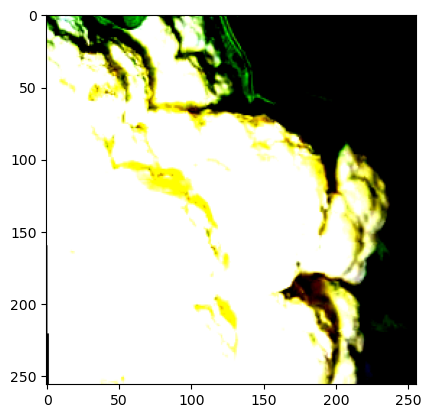

In [64]:
plt.imshow(test_ds[1].T)

In [54]:
# Validation
model.eval()
correct = 0
total = 0
validation_loader = train_loader
with torch.no_grad(): 
    for batch in validation_loader:
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.subtract(1).to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

validation_accuracy = 100 * correct / total
print(f"Validation Accuracy: {validation_accuracy:.2f}%")

Validation Accuracy: 24.68%


In [69]:
input = test_ds[2].to(device).unsqueeze(0)
pred = model(input)
print(str(1 + 4000)+','+str(torch.argmin(pred).detach().item() + 1) + '\n')

4001,2

